In [14]:
import numpy as np
import pandas as pd
from sklearn import linear_model
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sqlalchemy import create_engine
import statsmodels.formula.api as smf
from statsmodels.tsa.stattools import acf
from scipy.stats import bartlett, levene, jarque_bera, normaltest

import warnings
warnings.filterwarnings('ignore')

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

In [3]:
engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

house_prices_df = pd.read_sql_query('select * from houseprices', con=engine)

engine.dispose()

In [4]:
#Quick check on the number of rows and the columns in the dataframe
print(len(house_prices_df))
house_prices_df.iloc[:,:81].head(5)

1460


,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000


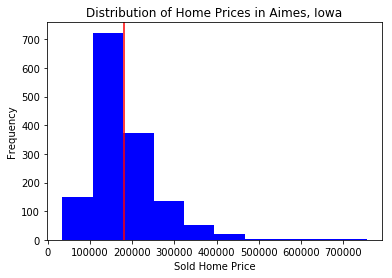

Mean house price in Aimes:  180921.19589041095


In [170]:
#Since we are estimating the saleprice I want to check the distribution
plt.hist(house_prices_df['saleprice'], color ='b')
plt.xlabel('Sold Home Price')
plt.ylabel('Frequency')
plt.axvline(house_prices_df['saleprice'].mean(), color='r', alpha=1.0)
plt.title('Distribution of Home Prices in Aimes, Iowa')
plt.show()
print('Mean house price in Aimes: ', house_prices_df['saleprice'].mean())

The sale price of the homes in Aimes, Iowa seems to be right-skewed with a few homes selling in the $ 700,000 range and the mean price at $ 180,000. Next, I want to dig into some of the variables and determine whether or not they would be a good fit for the model. Most of the data is categorical with string values for different classifiers, so the following evaluation will include digging into most of them one by one.

### Feature Engineering

In [12]:
house_prices_df['total_sf'] = house_prices_df['totalbsmtsf'] + house_prices_df['firstflrsf'] + house_prices_df['secondflrsf']

In [11]:
num_car_garage = pd.get_dummies(house_prices_df['garagecars'], prefix='car_garage')
house_prices_df = pd.concat([house_prices_df, num_car_garage], axis=1)

In [10]:
paved = pd.get_dummies(house_prices_df['paveddrive'], prefix='paved_driveway')
house_prices_df = pd.concat([house_prices_df, paved], axis=1)

In [9]:
garage_finish = pd.get_dummies(house_prices_df['garagefinish'], prefix='garagefinish')
house_prices_df = pd.concat([house_prices_df, garage_finish], axis=1)

In [7]:
#Does the house have an above average kitchen feature
house_prices_df['awesome_kitchen'] = 9999

In [8]:
house_prices_df.loc[(house_prices_df['kitchenqual'] == 'Ex') | (house_prices_df['kitchenqual'] == 'Gd'), 
                    ['awesome_kitchen']] = 1
house_prices_df.loc[(house_prices_df['kitchenqual'] == 'Fa') | (house_prices_df['kitchenqual'] == 'TA'), 
                    ['awesome_kitchen']] = 0
house_prices_df.awesome_kitchen.value_counts()

0    774
1    686
Name: awesome_kitchen, dtype: int64

In [5]:
#Is the garage attached to the house feature
house_prices_df['attached_garage'] = 9999
house_prices_df.loc[(house_prices_df['garagetype'] == 'Attchd') | (house_prices_df['garagetype'] == 'BuiltIn'), 
                    ['attached_garage']] = 1
house_prices_df.loc[(house_prices_df['garagetype'] != 'Attchd') & (house_prices_df['garagetype'] != 'BuiltIn'), 
                    ['attached_garage']] = 0
house_prices_df.attached_garage.value_counts()

1    958
0    502
Name: attached_garage, dtype: int64

### Linear Regression Modeling

In [20]:
features = house_prices_df[[
                    'awesome_kitchen', 
                    'total_sf', 
                    'paved_driveway_Y',
                    'attached_garage', 
                    'car_garage_3', 
                    'garagefinish_Fin'
                    ]
                   ]
Y = house_prices_df['saleprice']
X = features

lrm = linear_model.LinearRegression()
lrm.fit(X,Y)

print('\nCoefficients: \n', lrm.coef_)
print('\nIntercept: ', lrm.intercept_)
print('\nR^2: ', lrm.score(X,Y))


Coefficients: 
 [3.12772417e+04 4.83731098e+01 1.29968095e+04 1.52923751e+04
 5.96808142e+04 1.90616932e+04]

Intercept:  8091.679287145147

R^2:  0.7506969116498726


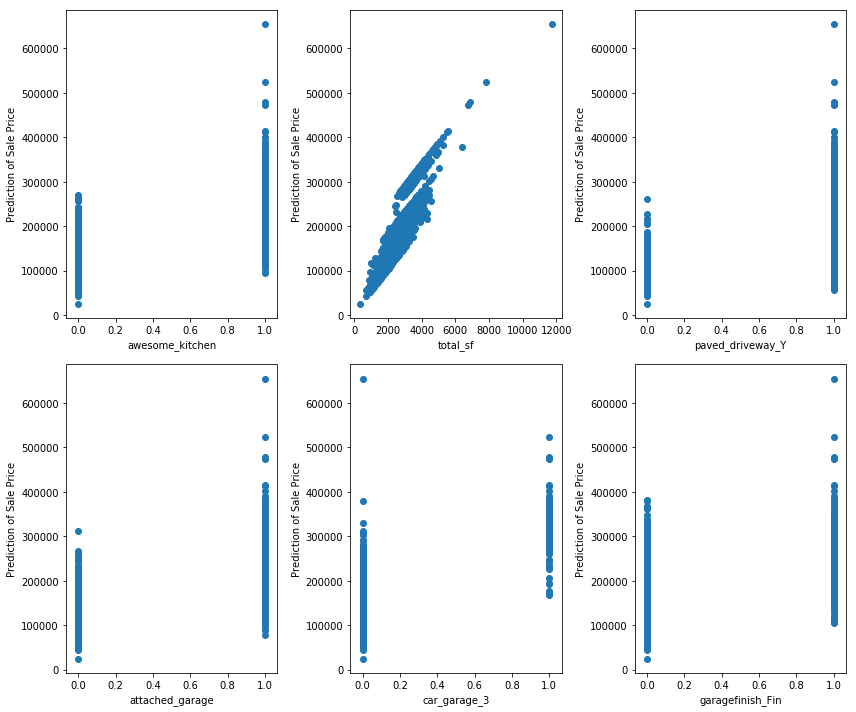

In [23]:
predictions = lrm.predict(X)

plt.figure(figsize=(12,10))
n=0
for col in X.columns:
    n +=1
    plt.subplot(2,3,n)
    plt.scatter(X[col], predictions)
    plt.xlabel(col)
    plt.ylabel('Prediction of Sale Price')
plt.tight_layout()
plt.show()

Confirming the mean error of the model is zero.
Mean of the errors in the model is: 1.356517577110088e-11

Running Barlett and Levene tests to check for homoscedasticity and comparing the predictions to the residuals to check for consistent distributions.
Bartlett test statistic is 422.301 and p-value is 7.70141e-94
Levene test statistic is 351.157 and p-value is 4.46862e-74


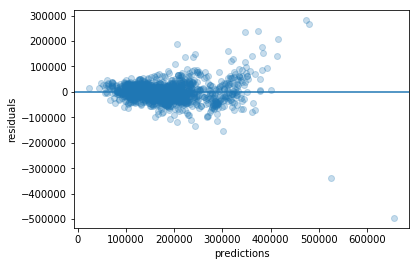

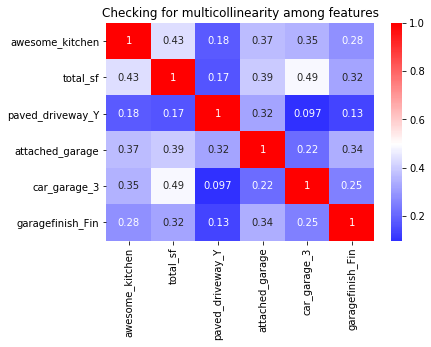

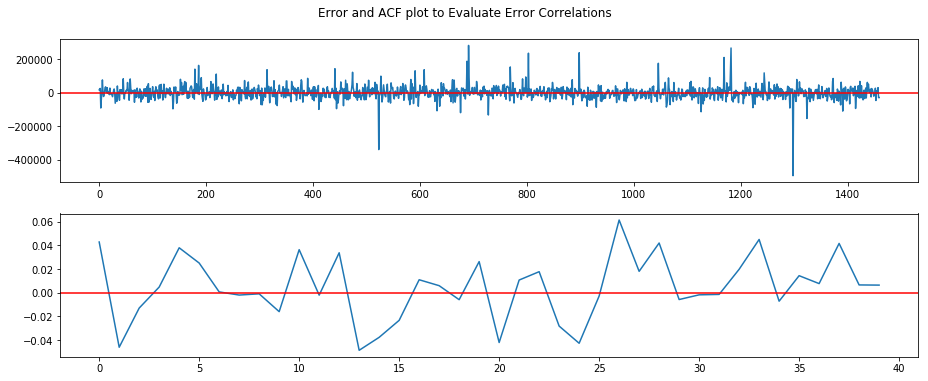

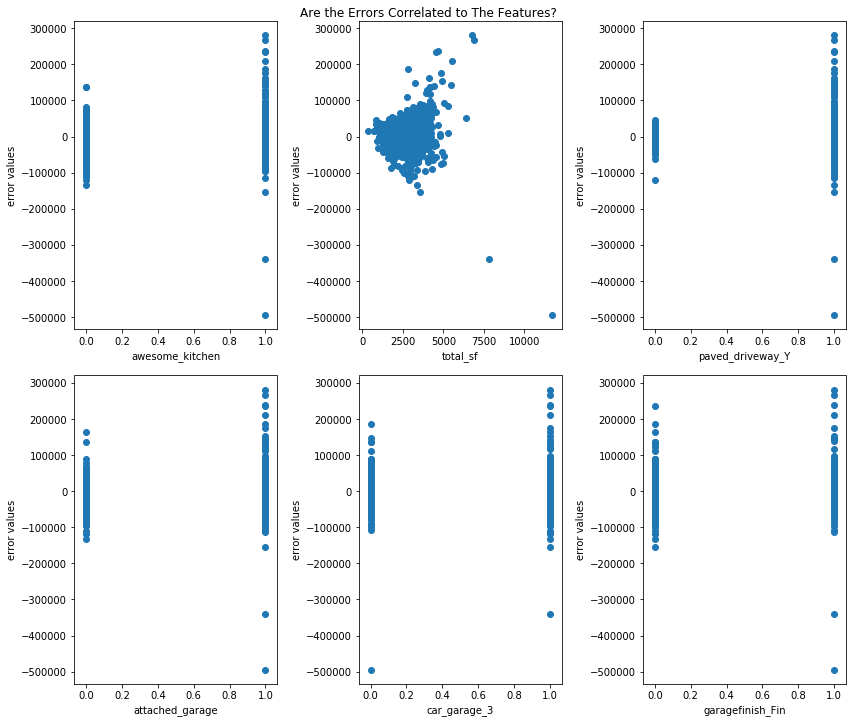

In [25]:
errors = Y - predictions
print('Confirming the mean error of the model is zero.')
print('Mean of the errors in the model is: {}\n'.format(np.mean(errors)))

#assumption 3: homoscedasticity
bart_stats = bartlett(predictions, errors)
lev_stats = levene(predictions, errors)
print('Running Barlett and Levene tests to check for homoscedasticity and comparing the predictions to the residuals to check for consistent distributions.')
print('Bartlett test statistic is {:3g} and p-value is {:3g}'.format(bart_stats[0], bart_stats[1]))
print('Levene test statistic is {:3g} and p-value is {:3g}'.format(lev_stats[0], lev_stats[1]))

plt.scatter(predictions, errors, alpha=0.25)
plt.xlabel('predictions')
plt.ylabel('residuals')
plt.axhline(0)
plt.show()

#assumption 4: low multicolllinearity
sns.heatmap(X.corr(), annot=True, cmap='bwr', center=0.5)
plt.title('Checking for multicollinearity among features')
plt.show

print('\n')
#assumption 5: error terms are uncorrelated to one another
acf_data = acf(errors)

plt.figure(figsize=(13,5))
plt.suptitle('Error and ACF plot to Evaluate Error Correlations', y=1.05, fontsize=12)

plt.subplot(2,1,1)
plt.plot(errors)
plt.axhline(y=0, color='red')

plt.subplot(2,1,2)
plt.plot(acf_data[1:])
plt.axhline(y=0, color='red')

plt.tight_layout()
plt.show()

print('\n')
#assumption 6: features should not be correlated with the errors
plt.figure(figsize=(12,10))

n=0
for col in X.columns:
    n +=1
    plt.subplot(2,3,n)
    plt.scatter(X[col], errors)
    plt.xlabel(col)
    plt.ylabel('error values')
plt.suptitle('Are the Errors Correlated to The Features?', y=1.0)
plt.tight_layout()
plt.show()

### Correlation Coefficients and Error Analysis

Using the charts above we can check the assumptions of a linear regression model. For conciseness I will only address the failed assumptions and what they mean for the prediction.

The Bartlett and Levene tests both have p-values < 0.05 which means we reject the null hypothesis that the errors are homoscedastic. Looking at the predictions vs. residuals plot, it looks like there are some outliers at the higher end of predicted home sales, which could be the issue.

Looking for multicollinearity shows that there is only one issue. There is a decent correlation between having 3 car garages and the total square footage of the house which could be causing issues with the prediction. Correlations of 0.49 aren't very strong, but it could be causing problems.

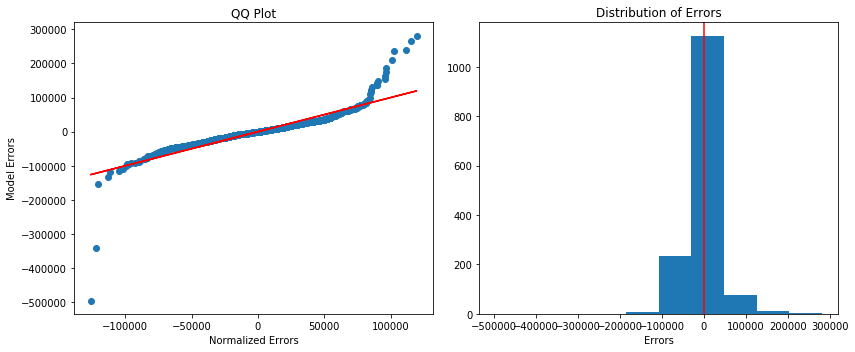

Jarque-Bera test statistic is 41343.874335607536 and p-value is 0.0
Normality test statistic is 494.7122562023767 and p-value is 3.7549010831594356e-108


In [26]:
normal_error = np.random.normal(np.mean(errors), np.std(errors), len(errors))

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(np.sort(normal_error), np.sort(errors))
plt.plot(normal_error, normal_error, color='red')
plt.xlabel('Normalized Errors')
plt.ylabel('Model Errors')
plt.title('QQ Plot')

plt.subplot(1,2,2)
plt.hist(errors)
plt.axvline(x=0, color='red')
plt.xlabel('Errors')
plt.title('Distribution of Errors')

plt.tight_layout()
plt.show()

jb_stats = jarque_bera(errors)
norm_stats = normaltest(errors)
print('Jarque-Bera test statistic is {} and p-value is {}'.format(jb_stats[0], jb_stats[1]))
print('Normality test statistic is {} and p-value is {}'.format(norm_stats[0], norm_stats[1]))

It does look like there is an issue with the normality of the errors. You can see on the QQ plot the deviation at the right side from the red normal line. The issue is harder to see in the histrogram, but it is confirmed with the Jarque-Bera and Normality p-values. Both tests result in p-values < 0.5 which means we would reject the null hypothesis that the errors are normally distributed. Therefore we probably need to do some work by including more features or transforming the target variable.